# Serverless Inference API

Hugging Face provides a [Serverless Inference API](https://huggingface.co/docs/api-inference/index) as a way for users to quickly test and evaluate over 500,000 publicly accessible (or your own privately permissioned) machine learning models with simple API calls ***for free***!

In this notebook recipe, we'll demonstrate several different ways you can query the Serverless Inference API while exploring various tasks including: 
- generating text with open LLMs
- creating images with stable diffusion
- reasoning over images with VLMs
- generating speech from text

The goal is to help you get started by covering the basics!


> [!TIP]
> Because we offer the Serverless Inference API for free, there are rate limits for regular Hugging Face users (~ few hundred requests per hour). For access to higher rate limits, you can [upgrade to a PRO account](https://huggingface.co/subscribe/pro) for just $9 per month. However, for high-volume, production inference workloads, check out our [Dedicated Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index) solution.


## Let's get started

To begin using the Serverless Inference API, you'll need a Hugging Face Hub profile: you can [register](https://huggingface.co/join) if you don't have one or [login here](https://huggingface.co/login) if you do. Next, you'll need to create a [User Access Token](https://huggingface.co/docs/hub/security-tokens). A token with `read` or `write` permissions will work, however, we highly encourage the use of fine-grained tokens. For this notebook, you'll need a fine-grained token with `Inference > Make calls to the serverless Inference API` user permissions.

With those steps out of the way, we can install our required packages and authenticate to the Hub with our User Access Token.

In [ ]:
%pip install -U huggingface_hub transformers

In [ ]:
import os
from huggingface_hub import interpreter_login, whoami, get_token

# running this will prompt you to enter your Hugging Face credentials
interpreter_login()

> [!TIP]
> We've used the `interpreter_login()` above to programatically login to the Hub. As an alternative, we could also use other methods like `notebook_login()` from the [Hub Python Library](https://huggingface.co/docs/huggingface_hub/en/package_reference/login) or `login` command from the [Hugging Face CLI tool](https://huggingface.co/docs/huggingface_hub/en/guides/cli#huggingface-cli-login).

Now, lets verify we're properly logged in using `whoami()` to print out the active username and the organizations your profile belongs to.

In [ ]:
whoami()

And then finally, we'll set our token as an environment variable for ease of access from our bash shell

In [3]:
os.environ["HF_TOKEN"] = get_token()

## Querying the Serverless Inference API

The Serverless Inference API exposes models on the Hub with a simple API:

`https://api-inference.huggingface.co/models/<MODEL_ID>`

where `<MODEL_ID>` corresponds to the name of the model repo on the Hub.

For example, [codellama/CodeLlama-7b-hf](https://huggingface.co/codellama/CodeLlama-7b-hf) becomes https://api-inference.huggingface.co/models/codellama/CodeLlama-7b-hf

### With an HTTP request

We can easily call this API with a simple `POST` request via the `curl` utility:

In [4]:
!curl https://api-inference.huggingface.co/models/codellama/CodeLlama-7b-hf \
	-X POST \
	-d '{"inputs": "A HTTP POST request is used to ", "parameters": {"temperature": 0.8, "max_new_tokens": 50, "seed": 42}}' \
	-H 'Content-Type: application/json' \
    -H "Authorization: Bearer $HF_TOKEN"

[{"generated_text":"A HTTP POST request is used to send data to a web server.\n\n# Example\n```javascript\npost(\"localhost:3000\", {foo: \"bar\"})\n  .then(console.log => console.log('success'))\n```\n\n"}]

Nice! The API responded with a continuation of our input prompt. But you might be wondering... how did the API know what to do with the payload? And how do I as a user know which parameters can be passed for a given model?

Behind the scenes, the inference API will dynamically load the requested model onto shared compute infrastructure to serve predictions. When the model is loaded, the Serverless Inference API will use the specified `pipeline_tag` from the Model Card (see [here](https://huggingface.co/codellama/CodeLlama-7b-hf/blob/main/README.md?code=true#L4)) to determine the appropriate inference task. You can reference the corresponding [task](https://huggingface.co/tasks) or [pipeline](https://huggingface.co/docs/transformers/en/main_classes/pipelines) documentation to find the allowed arguments.


> **Note:** If the requested model is not already loaded into memory at the time of request (which is determined by recent requests for that model), the Serverless Inference API will initially return a 503 response, before it can successfully respond with the prediction. Try again after a few moments to allow the model time to spin up.

### With the `huggingface_hub` Python library

To send your requests in Python, you can take advantage of the [`InferenceClient`](https://huggingface.co/docs/huggingface_hub/en/package_reference/inference_client#huggingface_hub.InferenceClient), a convenient utility available in the `huggingface_hub` Python library that allows you to easily make calls to the Serverless Inference API.

In [5]:
from huggingface_hub import InferenceClient

client = InferenceClient()
response = client.text_generation(
    prompt="A HTTP POST request is used to ",
    model="codellama/CodeLlama-7b-hf",
    temperature=0.8,
    max_new_tokens=50,
    seed=42,
    return_full_text=True,
)
print(response)

A HTTP POST request is used to send data to a web server.

# Example
```javascript
post("localhost:3000", {foo: "bar"})
  .then(console.log => console.log('success'))
```




Notice that with the `InferenceClient`, we specify just the model ID, and also pass arguments directly in the `text_generation()` method. We can easily inspect the function signature to see more details about how to use the task and its allowable parameters.

In [6]:
# uncomment the following line to see the function signature
# help(client.text_generation)

> [!TIP]
> In addition to Python, you can also use JavaScript to integrate inference calls inside your JS or node apps. Take a look at [huggingface.js](https://huggingface.co/docs/huggingface.js/index) to get started.

## Applications

Now that we know how the Serverless Inference API works, let's take it for a spin and learn a few tricks along the way.

### 1. Generating Text with Open LLMs

Text generation is a very common use case. However, interacting with open LLMs has some subtleties that are important to understand to avoid silent performance degradation. When it comes to text generation, the underlying language model may come in a couple different flavors:
- **Base models:** refer to plain, pre-trained language models like [codellama/CodeLlama-7b-hf](https://huggingface.co/codellama/CodeLlama-7b-hf) or [meta-llama/Meta-Llama-3-8B](https://huggingface.co/meta-llama/Meta-Llama-3-8B). These models are good at continuing generation from a provided prompt (like we saw in the example above). However, they have not been fine-tuned for conversational use like answering questions.
- **Instruction-tuned models:** are trained in a multi-task manner to follow a broad range of instructions like "Write me a recipe for chocolate cake". Models like [meta-llama/Meta-Llama-3-8B-Instruct](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) or [mistralai/Mistral-7B-Instruct-v0.3](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3) are trained in this manner. Instruction-tuned models will produce better responses to instructions than base models. Often, these models are also fine-tuned for multi-turn chat dialogs, making them great for conversational use cases.

These subtle differences are important to understand because they affect the way in which we should query a particular model. Instruct models are trained with [chat templates](https://huggingface.co/blog/chat-templates) that are specific to the model, so you need to be careful about the format the model expects and replicate it in your queries.

For example, [meta-llama/Meta-Llama-3-8B-Instruct](https://huggingface.co/meta-llama/Meta-Llama-3-8B-Instruct) uses the following prompt structure to delineate between system, user, and assistant dialog turns:

```
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{{ system_prompt }}<|eot_id|><|start_header_id|>user<|end_header_id|>

{{ user_msg_1 }}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{{ model_answer_1 }}<|eot_id|>
```

The special tokens, and prompt format vary model to model. To make sure we're using the correct format, we can rely on a model's [chat template](https://huggingface.co/docs/transformers/main/en/chat_templating) via it's tokenizer, as shown below.

In [8]:
from transformers import AutoTokenizer

# define the system and user messages
system_input = "You are an expert prompt engineer with artistic flair."
user_input = "Write a concise prompt for a fun image containing a llama and a cookbook. Only return the prompt."
messages = [
    {"role": "system", "content": system_input},
    {"role": "user", "content": user_input},
]

# load the model and tokenizer
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

# apply the chat template to the messages
prompt = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
print(f"\nPROMPT:\n-----\n\n{prompt}")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



PROMPT:
-----

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

You are an expert prompt engineer with artistic flair.<|eot_id|><|start_header_id|>user<|end_header_id|>

Write a concise prompt for a fun image containing a llama and a cookbook. Only return the prompt.<|eot_id|><|start_header_id|>assistant<|end_header_id|>




Notice how the `apply_chat_template()` method has taken the familiar list of messages and converted them into the properly formated string that our model expects. We can use this formatted string to pass to the Serverless Inference API's `text_generation` method.

In [10]:
llm_response = client.text_generation(
    prompt, model=model_id, max_new_tokens=250, seed=42
)
print(llm_response)

"A whimsical illustration of a llama proudly holding a cookbook, with a sassy expression and a sprinkle of flour on its nose, surrounded by a colorful kitchen backdrop with utensils and ingredients scattered about, as if the llama is about to whip up a culinary masterpiece."


Querying an LLM without adhering to the model's prompt template _will not_ produce any outright errors! However, it will result in poor quality outputs. Take a look at what happens when we pass the same system and user input, but **without** formatting it according to the chat template.

In [23]:
out = client.text_generation(
    system_input + " " + user_input, model=model_id, max_new_tokens=250, seed=42
)
print(out)

 Do not write the... 1 answer below »

You are an expert prompt engineer with artistic flair. Write a concise prompt for a fun image containing a llama and a cookbook. Only return the prompt. Do not write the image description.

A llama is sitting at a kitchen table, surrounded by cookbooks and utensils, with a cookbook open in front of it. The llama is wearing a chef's hat and holding a spatula. The cookbook is titled "Llama's Favorite Recipes" and has a llama on the cover. The llama is surrounded by a warm, golden light, and the kitchen is filled with the aroma of freshly baked bread. The llama is smiling and looking directly at the viewer, as if inviting them to join in the cooking fun. The image should be colorful, whimsical, and full of texture and detail. The llama should be the main focus of the image, and the cookbook should be prominently displayed. The background should be a warm, earthy color, such as terracotta or sienna. The overall mood of the image should be playful, inv

Yikes! The LLM hallucinated a non-sensical intro, repeated the prompt unexpectedly, and failed to remain concise. To simplify the prompting process and ensure the proper chat template is being used, the `InferenceClient` also offers a `chat_completion` method that abstracts away the `chat_template` details. This allows you to simply pass a list of messages:

In [12]:
for token in client.chat_completion(
    messages, model=model_id, max_tokens=250, stream=True, seed=42
):
    print(token.choices[0].delta.content)

"A
 whims
ical
 illustration
 of
 a
 fashion
ably
 dressed
 llama
 proudly
 holding
 a
 worn
,
 vintage
 cookbook
,
 with
 a
 warm
 cup
 of
 tea
 and
 a
 few
 freshly
 baked
 treats
 scattered
 around
,
 set
 against
 a
 cozy
 background
 of
 rustic
 wood
 and
 blo
oming
 flowers
."



#### Streaming 

In the example above, we've also set `stream=True` to enable streaming text from the endpoint. To learn about more functionality like this and about best practices when querying LLMs, we recommend reading more on these supporting resources:
1. [How to generate text: using different decoding methods for language generation with Transformers](https://huggingface.co/blog/how-to-generate)
2. [Text generation strategies](https://huggingface.co/docs/transformers/generation_strategies)
3. [Inference for PROs](https://huggingface.co/blog/inference-pro) - particularly the section on [controlling text generation](https://huggingface.co/blog/inference-pro#controlling-text-generation)
4. [Inference Client Docs](https://huggingface.co/docs/huggingface_hub/en/package_reference/inference_client#inference)


### 2. Creating Images with Stable Diffusion

The Serverless Inference API can be used for [many different tasks](https://huggingface.co/tasks). Here we'll use it to generate images with Stable Diffusion.

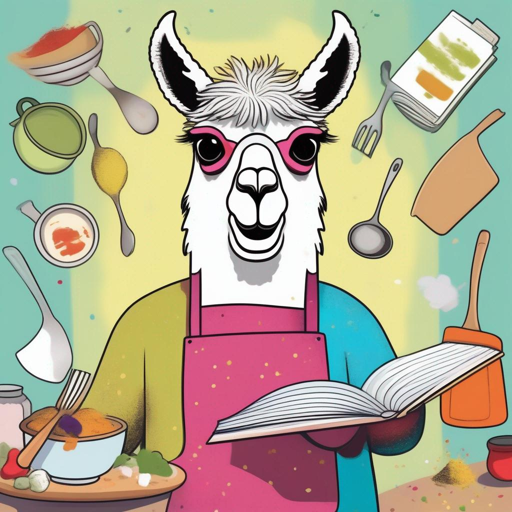

PROMPT:  "A whimsical illustration of a llama proudly holding a cookbook, with a sassy expression and a sprinkle of flour on its nose, surrounded by a colorful kitchen backdrop with utensils and ingredients scattered about, as if the llama is about to whip up a culinary masterpiece."


In [35]:
image = client.text_to_image(
    prompt=llm_response,
    model="stabilityai/stable-diffusion-xl-base-1.0",
    guidance_scale=8,
    seed=42,
)

display(image.resize((image.width // 2, image.height // 2)))
print("PROMPT: ", llm_response)

#### Caching

The `InferenceClient` will cache API responses by default. That means if you query the API with the same payload multiple times, you’ll see that the result returned by the API is exactly the same. Take a look:



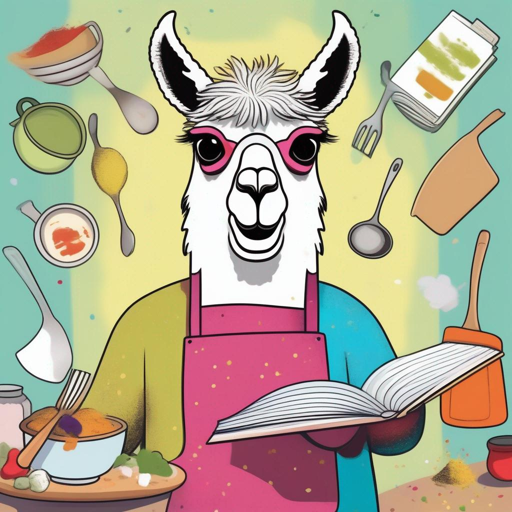

PROMPT:  "A whimsical illustration of a llama proudly holding a cookbook, with a sassy expression and a sprinkle of flour on its nose, surrounded by a colorful kitchen backdrop with utensils and ingredients scattered about, as if the llama is about to whip up a culinary masterpiece."


In [36]:
image = client.text_to_image(
    prompt=llm_response,
    model="stabilityai/stable-diffusion-xl-base-1.0",
    guidance_scale=8,
    seed=42,
)

display(image.resize((image.width // 2, image.height // 2)))
print("PROMPT: ", llm_response)

To force a different response each time, we can use a HTTP header to have the client ignore the cache and run a new generation: `x-use-cache: 0`.

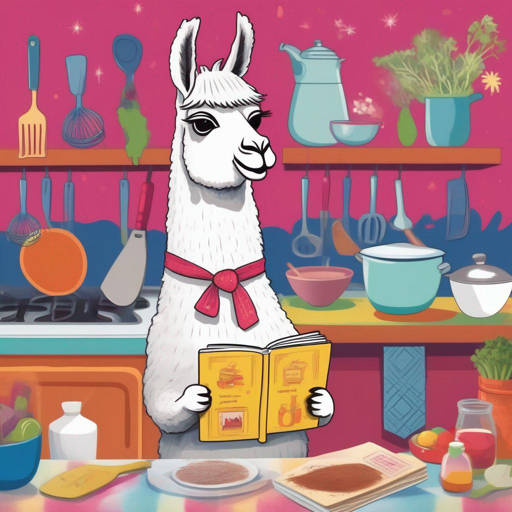

PROMPT:  "A whimsical illustration of a llama proudly holding a cookbook, with a sassy expression and a sprinkle of flour on its nose, surrounded by a colorful kitchen backdrop with utensils and ingredients scattered about, as if the llama is about to whip up a culinary masterpiece."


In [40]:
# turn caching off
client.headers["x-use-cache"] = "0"

# generate a new image with the same prompt
image = client.text_to_image(
    prompt=llm_response,
    model="stabilityai/stable-diffusion-xl-base-1.0",
    guidance_scale=8,
    seed=42,
)

display(image.resize((image.width // 2, image.height // 2)))
print("PROMPT: ", llm_response)

### 3. Reasoning Over Images with Idefics2

Vision language models (VLMs) can take both text and images as input simultaneously and produce text as output. This allows them to tackle many tasks from visual question answering to image captioning. Let's use the Serverless Inference API to query [Idefics2](https://huggingface.co/blog/idefics2), a powerful 8B parameter VLM, and have it write us a poem about our newly generated image.

We first need to convert our PIL image to a `base64` encoded string so that we can send it to the model over the network.

In [18]:
import base64
from io import BytesIO


def pil_image_to_base64(image):
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str


image_b64 = pil_image_to_base64(image)

Then, we need to properly format our text + image prompt using a chat template. See the [Idefics2 model card](https://huggingface.co/HuggingFaceM4/idefics2-8b) for specific details on prompt formatting. 

In [19]:
from transformers import AutoProcessor

# load the processor
vlm_model_id = "HuggingFaceM4/idefics2-8b-chatty"
processor = AutoProcessor.from_pretrained(vlm_model_id)

# define the user messages
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Write a short limerick about this image."},
        ],
    },
]

# apply the chat template to the messages
prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

# add the base64 encoded image to the prompt
image_input = f"data:image/jpeg;base64,{image_b64}"
image_input = f"![]({image_input})"
prompt = prompt.replace("<image>", image_input)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


And then finally call the Serverless API to get a prediction. In our case, a fun limerick about our generated image!

In [20]:
limerick = client.text_generation(
    prompt, model=vlm_model_id, max_new_tokens=200, seed=42
)
print(limerick)

 In the heart of a kitchen, so bright and so clean,
Lived a llama named Lulu, quite the culinary queen.
With a book in her hand, she'd read and she'd cook,
Her recipes were magic, her skills were so nook.
In her world, there was no room for defeat,
For Lulu, the kitchen was where she'd meet.


### 4. Generating Speech from Text

To finish up, let's use a transformers-based, text-to-audio model called [Bark](https://huggingface.co/suno/bark) to generate an audible voiceover for our poem.

In [21]:
tts_model_id = "suno/bark"
speech_out = client.text_to_speech(text=limerick, model=tts_model_id)

In [41]:
from IPython.display import Audio

display(Audio(speech_out, rate=24000))
print(limerick)

 In the heart of a kitchen, so bright and so clean,
Lived a llama named Lulu, quite the culinary queen.
With a book in her hand, she'd read and she'd cook,
Her recipes were magic, her skills were so nook.
In her world, there was no room for defeat,
For Lulu, the kitchen was where she'd meet.


## Next Steps

Thats it! In this notebook, we learned how to use the Serverless Inference API to query a variety of powerful transformer models. We've just scratched the surface of what you can do, and recommend checking out [the docs](https://huggingface.co/docs/api-inference/en/index) to learn more about what's possible.